In [140]:
# # Install Julia and IJulia
# ;curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.9/julia-1.9.3-linux-x86_64.tar.gz" -o julia.tar.gz
# ;tar -xvzf julia.tar.gz > /dev/null
# ;mv julia-1.9.3 /opt/julia
# ;ln -fs /opt/julia/bin/julia /usr/local/bin/julia

# # Install IJulia kernel
# ;julia -e 'using Pkg; Pkg.add("IJulia"); using IJulia;'



# LINMA2470 - Stochastic Modelling
## Project Statement - Part 1

# 1 - MDP environment

In [141]:
using POMDPs
using QuickPOMDPs
using Distributions
using Distributions: DiscreteUniform, pdf
using POMDPTools: Deterministic
using POMDPTools
using Statistics
using POMDPs: states, actions, transition, reward
using TabularTDLearning
using Random
using StatsBase: Weights
using Plots
using DataFrames
using POMDPs
using JuMP
using GLPK
using LinearAlgebra
using TabularTDLearning         # Q‑Learning & SARSA solvers
using POMDPTools: EpsGreedyPolicy, DiscreteBelief

In [142]:


### Définir le MDP corrigé EddyBikes ###
const MAX_INVENTORY = 20
const MAX_STORE = 10
const ORDER_SIZE = 5
const REPLENISH_WAREHOUSE_BATCH = 10

const holding_cost_store = 2
const holding_cost_parking = 4
const holding_cost_warehouse = 1
const order_cost = 20
const home_delivery_cost = 10
const stockout_penalty = 50

const demand_dist = DiscreteUniform(0, 7)

mdp = QuickMDP(
    states = [(s1, s2, sw) for s1 in 0:MAX_INVENTORY, s2 in 0:MAX_INVENTORY, sw in 0:MAX_INVENTORY],
    actions = [(a1, a2, aw) for a1 in 0:1, a2 in 0:1, aw in 0:1],
    discount = 0.99,

    gen = function (s, a, rng)
        s1, s2, sw = s

        a1, a2, aw = a
        if sw < 10 
            aw = 1
        else 
            aw = 0
        end

        # --- Réapprovisionnement usine vers warehouse ---
        new_sw = sw + (aw == 1 ? REPLENISH_WAREHOUSE_BATCH : 0)
        new_sw = min(new_sw, MAX_INVENTORY)

        # --- Commandes magasins ---
        order1 = a1 == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s1) : 0
        order2 = a2 == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s2) : 0

        total_requested = order1 + order2

        if total_requested <= new_sw
            actual_order1, actual_order2 = order1, order2
        else
            if s1 < s2
                actual_order1 = min(order1, new_sw)
                actual_order2 = new_sw - actual_order1
            else
                actual_order2 = min(order2, new_sw)
                actual_order1 = new_sw - actual_order2
            end
        end

        actual_order1 = min(actual_order1, ORDER_SIZE)
        actual_order2 = min(actual_order2, ORDER_SIZE)

        new_s1 = s1 + actual_order1
        new_s2 = s2 + actual_order2
        new_sw -= (actual_order1 + actual_order2)

        # --- Demandes clients ---
        d1 = rand(rng, demand_dist)
        d2 = rand(rng, demand_dist)

        sold1 = min(new_s1, d1)
        remaining_demand1 = d1 - sold1
        delivered1 = min(remaining_demand1, new_sw)
        lost_sales1 = remaining_demand1 - delivered1

        new_s1 -= sold1
        new_sw -= delivered1

        sold2 = min(new_s2, d2)
        remaining_demand2 = d2 - sold2
        delivered2 = min(remaining_demand2, new_sw)
        lost_sales2 = remaining_demand2 - delivered2

        new_s2 -= sold2
        new_sw -= delivered2

        # --- Coûts ---
        cost = 0
        cost += (a1 == 1 ? order_cost : 0) + (a2 == 1 ? order_cost : 0)
        #cost += (aw == 1 ? order_cost : 0)

        in_store1 = min(new_s1, MAX_STORE)
        in_parking1 = max(new_s1 - MAX_STORE, 0)
        cost += in_store1 * holding_cost_store + in_parking1 * holding_cost_parking

        cost += new_s2 * holding_cost_store
        cost += new_sw * holding_cost_warehouse
        cost += (delivered1 + delivered2) * home_delivery_cost
        cost += (lost_sales1 + lost_sales2) * stockout_penalty

        r = -cost
        return ((new_s1, new_s2, new_sw), r, (d1, d2))
    end,

    initialstate = Deterministic((10, 10, 10))
)


QuickMDP{Base.UUID("ddb20994-10b1-4605-a613-3c0841e8aa77"), Tuple{Int64, Int64, Int64}, Tuple{Int64, Int64, Int64}, @NamedTuple{stateindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, isterminal::Bool, actionindex::Dict{Tuple{Int64, Int64, Int64}, Int64}, initialstate::Deterministic{Tuple{Int64, Int64, Int64}}, states::Array{Tuple{Int64, Int64, Int64}, 3}, actions::Array{Tuple{Int64, Int64, Int64}, 3}, discount::Float64, gen::var"#110#113"}}((stateindex = Dict((19, 5, 6) => 2771, (6, 13, 14) => 6454, (20, 16, 1) => 798, (3, 9, 8) => 3721, (0, 2, 19) => 8422, (16, 15, 16) => 7388, (14, 12, 1) => 708, (11, 13, 15) => 6900, (16, 5, 3) => 1445, (18, 6, 19) => 8524…), isterminal = false, actionindex = Dict((0, 0, 0) => 1, (1, 1, 1) => 8, (1, 1, 0) => 4, (0, 1, 1) => 7, (0, 1, 0) => 3, (1, 0, 1) => 6, (1, 0, 0) => 2, (0, 0, 1) => 5), initialstate = Deterministic{Tuple{Int64, Int64, Int64}}((10, 10, 10)), states = [(0, 0, 0) (0, 1, 0) … (0, 19, 0) (0, 20, 0); (1, 0, 0) (1, 1, 0) … (1, 19, 0) (1,

In [180]:
rng = MersenneTwister(42)

scenarios = [
    ((4, 3, 10), (1, 0, 0)),  # store1 commande, pas store2, pas d'usine
    ((4, 3, 10), (1, 0, 1)),  # store1 commande, et réappro usine
    ((18, 18, 5), (1, 1, 1)), # magasins pleins, commande depuis usine
    ((5, 5, 0), (1, 1, 0)),   # entrepôt vide, demande forte
    ((0, 0, 20), (0, 0, 0)),  # rien ne se passe
    ((19, 19, 20), (0, 0, 1)),# stocks pleins, mais entrepôt recharge
    ((10, 10, 5), (1, 0, 1)), # 1 magasin commande, usine réapprovisionne
    ((7, 8, 2), (1, 1, 0)),   # compétition entre magasins, sans usine
    ((0, 20, 10), (1, 1, 1)), # un vide un plein, recharge usine
    ((2, 2, 2), (0, 1, 1)),   # un seul magasin commande
    ((15, 5, 0), (0, 1, 0)),  # un magasin haut stock, autre bas
]

for (s, a) in scenarios
    sp, r, d = POMDPs.gen(mdp3, s, a, rng)
    println("From $s --(a=$a)--> $sp,  Demands: $d, Reward = $r")
end


From (4, 3, 10) --(a=(1, 0, 0))--> (8, 0, 1),  Demands: (1, 7), Reward = -77
From (4, 3, 10) --(a=(1, 0, 1))--> (6, 0, 3),  Demands: (3, 5), Reward = -55
From (18, 18, 5) --(a=(1, 1, 1))--> (15, 15, 11),  Demands: (5, 5), Reward = -121
From (5, 5, 0) --(a=(1, 1, 0))--> (3, 4, 0),  Demands: (7, 6), Reward = -54
From (0, 0, 20) --(a=(0, 0, 0))--> (0, 0, 19),  Demands: (1, 0), Reward = -29
From (19, 19, 20) --(a=(0, 0, 1))--> (18, 17, 20),  Demands: (1, 2), Reward = -106
From (10, 10, 5) --(a=(1, 0, 1))--> (10, 3, 10),  Demands: (5, 7), Reward = -56
From (7, 8, 2) --(a=(1, 1, 0))--> (11, 6, 2),  Demands: (1, 7), Reward = -78
From (0, 20, 10) --(a=(1, 1, 1))--> (4, 17, 5),  Demands: (1, 3), Reward = -87
From (2, 2, 2) --(a=(0, 1, 1))--> (2, 2, 7),  Demands: (0, 5), Reward = -35
From (15, 5, 0) --(a=(0, 1, 0))--> (8, 9, 5),  Demands: (7, 1), Reward = -59


# 2 - Q-Learning method

In [182]:
n_states = 21 # 0 -> 20
n_actions = 2 # 0 ou 1
# Q = zeros(Float64, n_states, n_actions)


function my_Q_learning(
    mdp, α, ϵ, Q0;
    s_space = (0:20, 0:20, 0:20),              # ranges for (s1, s2, s3)
    a_space = Iterators.product(0:1, 0:1, 0:1),# list of 3-element actions
    epochs = 100, iterations = 10_000,
    s0 = (10, 10, 10), γ = 0.99
)
    rng = MersenneTwister(12344)

    n_s1, n_s2, n_s3 = length.(s_space)
    Q_temp = zeros(Float64, n_s1, n_s2, n_s3, 2, 2, 2)  # assumes binary actions for each dim
    Q_temp .= Q0

    ERR = []
    all_actions = collect(a_space)

    for i in 1:iterations
        s = s0

        for t in 1:epochs
            # ϵ-greedy action selection
            a = rand(rng) < ϵ ? rand(rng, all_actions) : begin
                max_a = nothing
                max_q = -Inf
                for a_candidate in all_actions
                    q_val = Q_temp[s[1]+1, s[2]+1, s[3]+1, a_candidate[1]+1, a_candidate[2]+1, a_candidate[3]+1]
                    if q_val > max_q
                        max_q = q_val
                        max_a = a_candidate
                    end
                end
                max_a
            end

            sp, r, _ = POMDPs.gen(mdp, s, a, rng)

            # Q update
            current_q = Q_temp[s[1]+1, s[2]+1, s[3]+1, a[1]+1, a[2]+1, a[3]+1]
            future_q = maximum(Q_temp[sp[1]+1, sp[2]+1, sp[3]+1, :, :, :])
            Q_temp[s[1]+1, s[2]+1, s[3]+1, a[1]+1, a[2]+1, a[3]+1] += α * (r + γ * future_q - current_q)

            s = sp
        end

        if i % 10 == 0
            err = norm(Q0 - Q_temp)
            push!(ERR, err)
            Q0 .= Q_temp
        end
    end

    return Q_temp, ERR
end


my_Q_learning (generic function with 1 method)

In [186]:
α = 0.1
ϵ = 0.1
s0 = (10, 10, 10)

# Q-table: 21 x 21 x 21 states, 2 x 2 x 2 actions
Q = zeros(Float64, n_states, n_states, n_states, n_actions, n_actions, n_actions)

Q, ERR = my_Q_learning(mdp, α, ϵ, Q, s0 = s0, epochs = 30, iterations = 1000)


([-107.2457937479755 -67.49718785832899 … 0.0 0.0; -47.46327610441882 -15.146286480204127 … 0.0 0.0; … ; -10.100000000000001 0.0 … 0.0 0.0; -11.600000000000001 0.0 … 0.0 0.0;;; -93.77471699038722 -21.06581155088732 … -8.3 0.0; -31.99279706925369 -7.161799146464 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; -11.0 -10.8 … 0.0 0.0;;; -86.87650042664981 -34.24464052406366 … -8.783100000000001 0.0; -49.15888705992263 -8.426946707670002 … 0.0 0.0; … ; -13.100000000000001 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; -29.157695546756123 -29.7167853621139 … 0.0 0.0; -17.743668752022174 -16.475661382908022 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -6.4 -15.3840297394 … 0.0 0.0; -8.200000000000001 -12.366685 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; -118.0871340997159 -59.17394052101934 … 0.0 0.0; -59.93359643674801 -5.074200000000001 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -85.63664767907

In [189]:
α = 0.1
ϵ = 0.01
s0 = (10, 10, 10)

# For states (0:20, 0:20, 0:20) and actions (0 or 1 in each of 3 dims)
Q = zeros(Float64, 21, 21, 21, 2, 2, 2)

Q, ERR2 = my_Q_learning(mdp, α, ϵ, Q, s0 = s0, epochs = 30, iterations = 10_000)


([-287.8883268978011 -237.50639525544338 … -25.187150053022066 -12.011000000000001; -218.85646071490535 -95.55431866774045 … -4.6000000000000005 -4.2; … ; -25.775688531485134 -12.669200000000002 … 0.0 -8.200000000000001; -15.14350261207008 -9.937470000000001 … 0.0 0.0;;; -227.18746621559086 -182.08510916040495 … -9.2607732131 -5.097572710000001; -167.0768237701975 -81.82422705005808 … -7.0 -5.501213950837541; … ; -28.72902765990964 0.0 … 0.0 0.0; -5.5 -6.9 … 0.0 0.0;;; -218.34015883879417 -165.6925830446151 … -23.089602388518394 -22.129009757357835; -157.3825875738961 -92.54731777869388 … -9.842500000000001 -4.7346; … ; -19.663028559759766 -11.4 … 0.0 0.0; -11.3 -7.4 … 0.0 -7.2;;; … ;;; -149.14536532231728 -103.39417416484613 … -6.1000000000000005 -11.0; -130.38097177529676 -50.70161101543037 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; -9.600000000000001 -6.6000000000000005 … 0.0 0.0;;; -79.62567905372077 -68.06090883623637 … -10.9 0.0; -76.43177391402054 -47.95890583995067 … 0.0 0.0; … ; 0.0 0.

In [190]:
for e in ERR2
    push!(ERR, e)
end

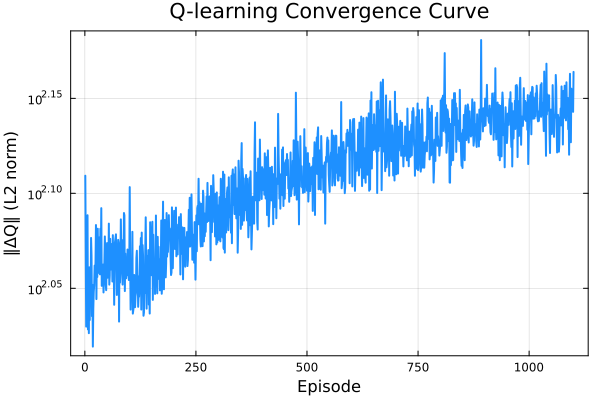

In [191]:
plot(ERR;
    xlabel = "Episode",
    ylabel = "‖ΔQ‖ (L2 norm)",
    yscale = :log10,
    lw = 2,
    color = :dodgerblue,
    legend = false,
    title = "Q-learning Convergence Curve",
    grid = :on,
    framestyle = :box
)

Benchmarking the Q_learning

In [192]:
function benchmark_policy(policy, mdp; episodes=1_000_000, horizon=30, rng=MersenneTwister(42))
    total_rewards = zeros(episodes)

    for ep in 1:episodes
        s = 10  # start state
        ep_reward = 0.0

        for t in 1:horizon
            a = policy[s + 1]  # select action from learned policy
            sp, r, _ = POMDPs.gen(mdp, s, a, rng)  # simulate next step
            ep_reward += r
            s = sp
        end

        total_rewards[ep] = ep_reward
    end

    mean_reward = mean(total_rewards)
    std_reward = std(total_rewards)

    return mean_reward, std_reward, total_rewards
end

benchmark_policy (generic function with 1 method)

In [193]:
policy = [argmax(Q[s+1, :]) - 1 for s in 0:MAX_INVENTORY]
mean_r, std_r, rewards = benchmark_policy(policy, mdp)

println("Benchmark results for learned Q-learning policy:")
println("  Mean total reward over episodes: $mean_r")
println("  Std. deviation: $std_r")

using Plots
histogram(rewards, bins=30, xlabel="Total Reward", ylabel="Frequency", title="Policy Benchmark Performance")

BoundsError: BoundsError: attempt to access 21×21×21×2×2×2 Array{Float64, 6} at index [1, 1:21]

In [151]:
N_eval = 1_000_0
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean = zeros(length(alphas), length(epsilons))
returns_std = zeros(length(alphas), length(epsilons))

println("Starting benchmark for the Q_learning for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
   for (j, ϵ) in enumerate(epsilons)
      println("α = $α | ϵ = $ϵ")
      Q = zeros(Float64, n_states, n_actions)
      Q, _ = my_Q_learing(mdp, α, ϵ, Q, epochs = 30, iterations = 1_000_0)
      π = [argmax(Q[s+1, :]) - 1 for s in states(mdp)]

      total_rewards = zeros(N_eval)

      for k in 1:N_eval
         s = 10
         total_r = 0.0

         for t in 1:30
            a = π[s+1]
            s, r  = POMDPs.gen(mdp, s, a, rng)
            # s, r = out.sp, out.r
            # total_r += r * discount(mdp)^(t - 1)
            # total_r += r
            total_r = r +  total_r * 0.99
         end
         total_rewards[k] = total_r
      end

      mean_r = mean(total_rewards)
      std_r = std(total_rewards)
      # mean_r, std_r, rewards = benchmark_policy(π, mdp)
      returns_mean[i, j] = mean_r
      returns_std[i, j] = std_r

   end
end


Starting benchmark for the Q_learning for :
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2


BoundsError: BoundsError: attempt to access Int64 at index [2]

In [152]:
returns_mean

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

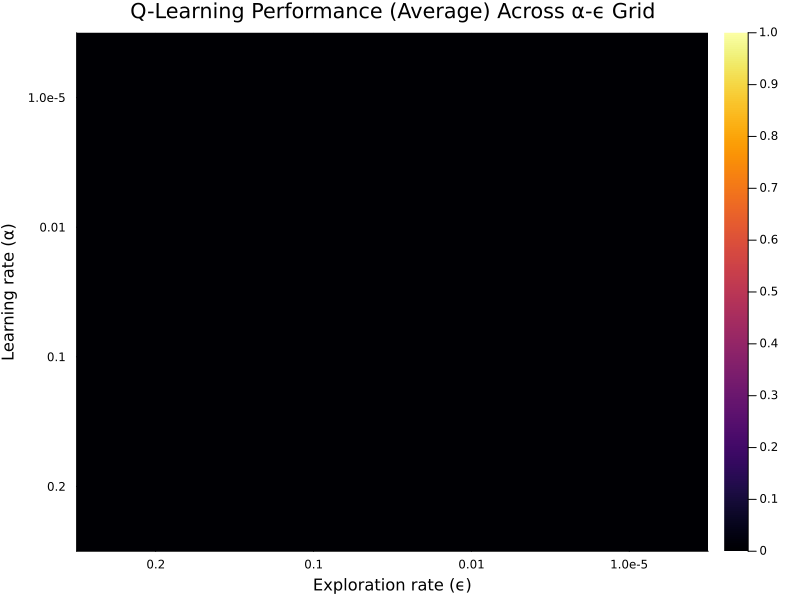

In [153]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "Q-Learning Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

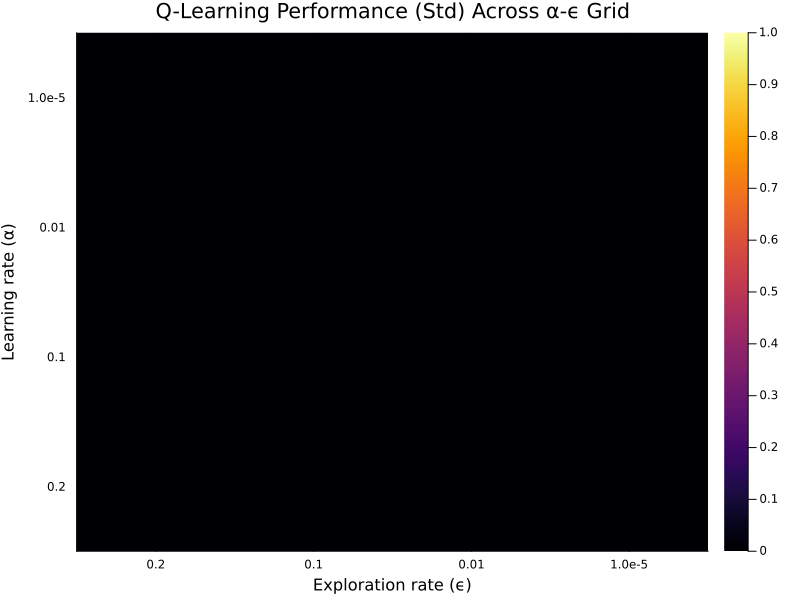

In [154]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_std;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "Q-Learning Performance (Std) Across α-ϵ Grid",
    # c = :viridis,
)

# 3 - SARSA Method

In [155]:
function my_SARSA(mdp, α, ϵ, Q0; n_states = 21, n_actions = 2, epochs = 100, iterations = 10_000, s0 = 10, γ = 0.99)
    rng = MersenneTwister(12344)

    Q = copy(Q0)
    ERR = []

    for i in 1:iterations
        s = s0
        a = rand() < ϵ ? rand([0, 1]) : argmax(Q[s + 1, :]) - 1

        for t in 1:epochs
            sp, r, _ = POMDPs.gen(mdp, s, a, rng)
            ap = rand() < ϵ ? rand([0, 1]) : argmax(Q[sp + 1, :]) - 1

            Q[s + 1, a + 1] += α * (r + γ * Q[sp + 1, ap + 1] - Q[s + 1, a + 1])

            s = sp
            a = ap
        end

        if i % 10 == 0
            err = norm(Q - Q0)
            push!(ERR, err)
            Q0 .= Q
        end
    end

    return Q, ERR
end


my_SARSA (generic function with 1 method)

In [156]:
s = 10
α = 0.1
ϵ = 0.1
Q = zeros(Float64, n_states, n_actions)
Q, ERR = my_SARSA(mdp, α, ϵ, Q, epochs = 30, iterations = 1000)

BoundsError: BoundsError: attempt to access Int64 at index [2]

In [157]:
s = 10
α = 0.1
ϵ = 0.01
Q, ERR2 = my_SARSA(mdp, α, ϵ, Q, epochs = 30, iterations = 10000)

BoundsError: BoundsError: attempt to access Int64 at index [2]

In [158]:
for e in ERR2
    push!(ERR, e)
end

UndefVarError: UndefVarError: `ERR2` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [159]:
plot(ERR;
    xlabel = "Episode",
    ylabel = "‖ΔQ‖ (L2 norm)",
    yscale = :log10,
    lw = 2,
    color = :dodgerblue,
    legend = false,
    title = "SARSA Convergence Curve",
    grid = :on,
    framestyle = :box
)


UndefVarError: UndefVarError: `ERR` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Benchmarking SARSA

In [160]:
N_eval = 10_000
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean_sarsa = zeros(length(alphas), length(epsilons))
returns_std_sarsa = zeros(length(alphas), length(epsilons))

println("Starting benchmark for the SARSA for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
    for (j, ϵ) in enumerate(epsilons)
        println("α = $α | ϵ = $ϵ")
        Q = zeros(Float64, n_states, n_actions)
        Q, _ = my_SARSA(mdp, α, ϵ, Q, epochs = 30, iterations = 10_000)
        π = [argmax(Q[s+1, :]) - 1 for s in states(mdp)]

        total_rewards = zeros(N_eval)

        for k in 1:N_eval
            s = 10
            total_r = 0.0

            for t in 1:30
                a = π[s+1]
                s, r = POMDPs.gen(mdp, s, a, rng)
                total_r = r + total_r * 0.99
            end

            total_rewards[k] = total_r
        end

        mean_r = mean(total_rewards)
        std_r = std(total_rewards)

        returns_mean_sarsa[i, j] = mean_r
        returns_std_sarsa[i, j] = std_r
    end
end

Starting benchmark for the SARSA for :
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2


BoundsError: BoundsError: attempt to access Int64 at index [2]

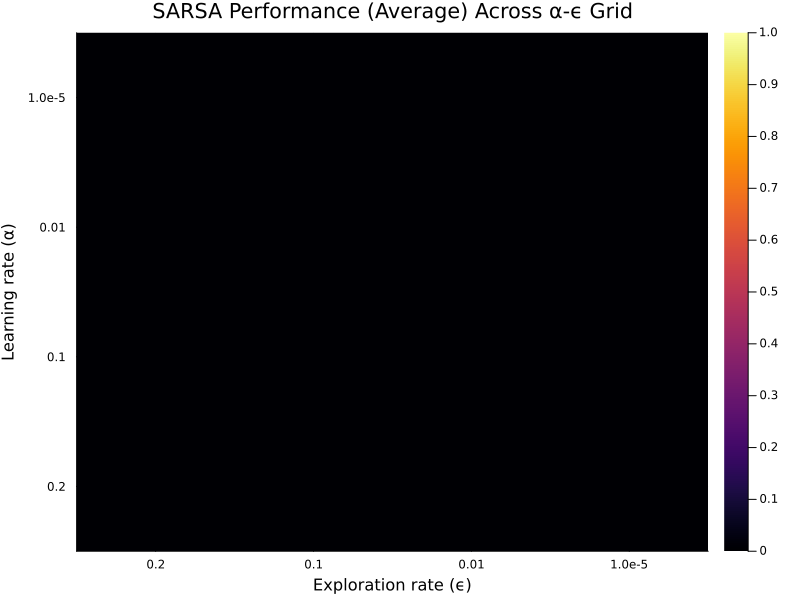

In [161]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean_sarsa;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "SARSA Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

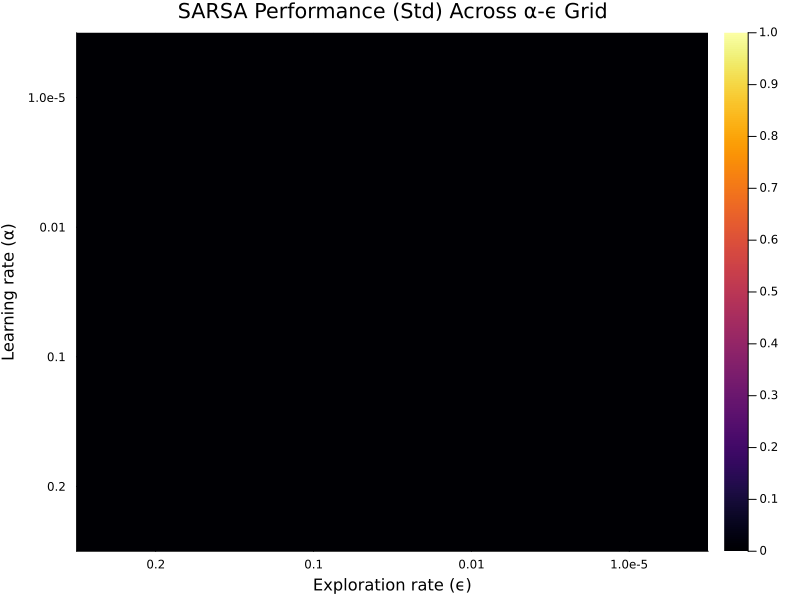

In [162]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_std_sarsa;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "SARSA Performance (Std) Across α-ϵ Grid",
    # c = :viridis,
)

# 4 - Comparison with POMDS.jl

In [163]:
mdp_q3 = QuickMDP(
    states     = 0:MAX_INVENTORY,
    actions    = [0, 1],
    discount   = 0.99,

    gen = function (s, a, rng)
        order_qty = a == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s) : 0
        new_stock = s + order_qty

        d = rand(rng, demand_dist)
        sold = min(d, new_stock)
        sp = new_stock - sold

        lost_sales = max(d - new_stock, 0)

        in_store = min(sp, MAX_STORE)
        in_parking = max(sp - MAX_STORE, 0)

        cost = 0
        cost += a == 1 ? order_cost : 0
        cost += in_store * holding_cost_store
        cost += in_parking * holding_cost_parking
        cost += lost_sales * stockout_penalty

        r = -cost

        return (sp=sp, r=r)
    end,

    initialstate = Deterministic(10)
)

QuickMDP{Base.UUID("89df5069-ff12-4794-911a-ce7d962565d8"), Int64, Int64, @NamedTuple{stateindex::Dict{Int64, Int64}, isterminal::Bool, actionindex::Dict{Int64, Int64}, initialstate::Deterministic{Int64}, states::UnitRange{Int64}, actions::Vector{Int64}, discount::Float64, gen::var"#123#124"}}((stateindex = Dict(5 => 6, 16 => 17, 7 => 8, 20 => 21, 12 => 13, 8 => 9, 17 => 18, 1 => 2, 19 => 20, 0 => 1…), isterminal = false, actionindex = Dict(0 => 1, 1 => 2), initialstate = Deterministic{Int64}(10), states = 0:20, actions = [0, 1], discount = 0.99, gen = var"#123#124"()))

QLearningSolver

In [164]:
N_eval = 1_000_0
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean = zeros(length(alphas), length(epsilons))
returns_std = zeros(length(alphas), length(epsilons))


function policy_vector(pol)
   [action(pol, s) for s in states(mdp_q3)]
end

println("Starting benchmark for the QLearningSolver for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
   for (j, ϵ) in enumerate(epsilons)
      println("α = $α | ϵ = $ϵ")

      ql_solver   = QLearningSolver(
                 exploration_policy = EpsGreedyPolicy(mdp_q3, ϵ),
                 learning_rate      = α,
                 n_episodes         = 1_000_0,
                 max_episode_length = 30,
                 eval_every         = 100,
                 n_eval_traj        = 100)


      ql_policy = solve(ql_solver,   mdp_q3)

      π_ql = policy_vector(ql_policy)


      total_rewards = zeros(N_eval)

      for k in 1:N_eval
         s = 10
         total_r = 0.0

         rng =  MersenneTwister()
         for t in 1:30
            a = π_ql[s+1]
            s, r  = POMDPs.gen(mdp, s, a, rng)
            # s, r = out.sp, out.r
            total_r += r * discount(mdp)^(t - 1)
            # total_r += r
            # total_r = r +  total_r * 0.99
         end
         total_rewards[k] = total_r
      end

      mean_r = mean(total_rewards)
      std_r = std(total_rewards)
      # mean_r, std_r, rewards = benchmark_policy(π, mdp)
      returns_mean[i, j] = mean_r
      returns_std[i, j] = std_r

   end
end

Starting benchmark for the QLearningSolver for :
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2
On Iteration 100, Returns: -1473.8020671881468
On Iteration 200, Returns: -1193.1011186594903
On Iteration 300, Returns: -1431.5888837321356
On Iteration 400, Returns: -1575.9547609412475
On Iteration 500, Returns: -734.2938979579491
On Iteration 600, Returns: -839.569208879355
On Iteration 700, Returns: -637.9587160196884
On Iteration 800, Returns: -938.0745476966662
On Iteration 900, Returns: -650.9255312766724
On Iteration 1000, Returns: -636.1961176106626
On Iteration 1100, Returns: -735.302350010706
On Iteration 1200, Returns: -635.7952476813773
On Iteration 1300, Returns: -640.2231531016022
On Iteration 1400, Returns: -636.3256606608106
On Iteration 1500, Returns: -641.3042384966907
On Iteration 1600, Returns: -631.1764547230915
On Iteration 1700, Returns: -633.0116471649933
On Iteration 1800, Returns: -636.6959832885838
On Iteration 1900, Retur

BoundsError: BoundsError: attempt to access Int64 at index [2]

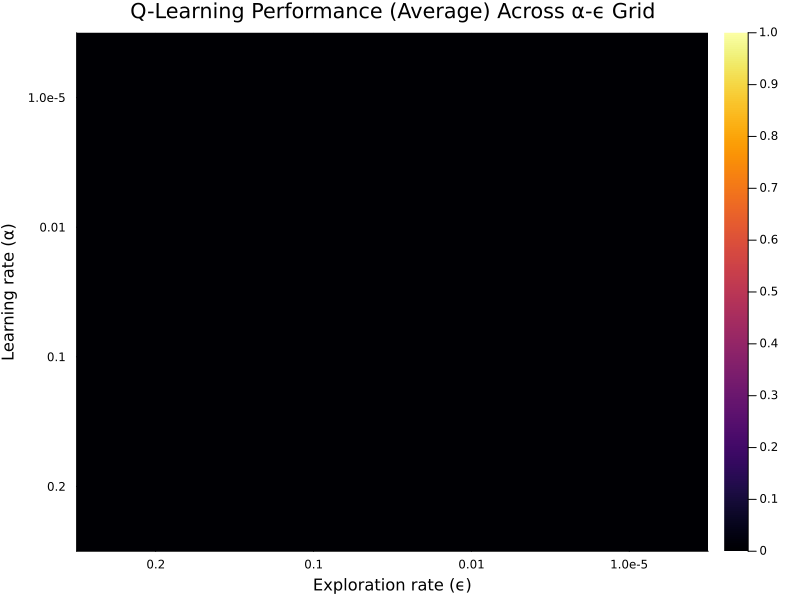

In [165]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "Q-Learning Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

In [166]:
returns_mean

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

SARSASolver

In [167]:
N_eval = 1_000_0
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean = zeros(length(alphas), length(epsilons))
returns_std = zeros(length(alphas), length(epsilons))

function policy_vector(pol)
   [action(pol, s) for s in states(mdp_q3)]
end

println("Starting benchmark for the SARSASolver for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
   for (j, ϵ) in enumerate(epsilons)
      println("α = $α | ϵ = $ϵ")

      sarsa_solver   = SARSASolver(
                 exploration_policy = EpsGreedyPolicy(mdp_q3, ϵ),
                 learning_rate      = α,
                 n_episodes         = 1_000_0,
                 max_episode_length = 30,
                 eval_every         = 100,
                 n_eval_traj        = 100)


      sarsa_policy = solve(sarsa_solver,   mdp_q3)

      π_sarsa = policy_vector(sarsa_policy)


      total_rewards = zeros(N_eval)

      for k in 1:N_eval
         s = 10
         total_r = 0.0

         rng =  MersenneTwister()
         for t in 1:30
            a = π_sarsa[s+1]
            s, r  = POMDPs.gen(mdp, s, a, rng)
            # s, r = out.sp, out.r
            total_r += r * discount(mdp)^(t - 1)
            # total_r += r
            # total_r = r +  total_r * 0.99
         end
         total_rewards[k] = total_r
      end

      mean_r = mean(total_rewards)
      std_r = std(total_rewards)
      # mean_r, std_r, rewards = benchmark_policy(π, mdp)
      returns_mean[i, j] = mean_r
      returns_std[i, j] = std_r

   end
end


Starting benchmark for the SARSASolver for :
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2
On Iteration 100, Returns: -1098.5388294478814
On Iteration 200, Returns: -1032.2124796341536
On Iteration 300, Returns: -1190.8991175607448
On Iteration 400, Returns: -1016.6267013665993
On Iteration 500, Returns: -828.5226901478427
On Iteration 600, Returns: -874.26901184201
On Iteration 700, Returns: -949.5888185022164
On Iteration 800, Returns: -751.4865474816447
On Iteration 900, Returns: -763.7171542148482
On Iteration 1000, Returns: -843.9000545218806
On Iteration 1100, Returns: -698.7988961040166
On Iteration 1200, Returns: -744.6169579041017
On Iteration 1300, Returns: -752.5744792718201
On Iteration 1400, Returns: -704.7348833445078
On Iteration 1500, Returns: -683.0388241310022
On Iteration 1600, Returns: -715.3280663975197
On Iteration 1700, Returns: -677.5451479300912
On Iteration 1800, Returns: -635.155306626595
On Iteration 1900, Returns: -

BoundsError: BoundsError: attempt to access Int64 at index [2]

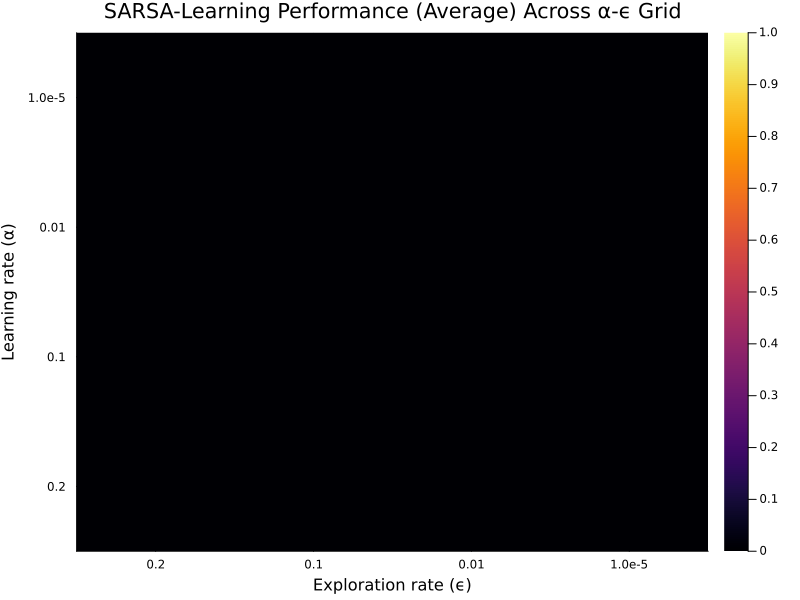

In [168]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "SARSA-Learning Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

In [169]:
returns_mean

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

# 5 - Optimal policy

## Value iteration

In [170]:
function estimate_transitions_and_rewards(mdp; n_samples=1000)
    n_states = MAX_INVENTORY + 1
    n_actions = 2

    P = [Dict{Int, Float64}() for s in 0:MAX_INVENTORY, a in 0:1]
    R = zeros(n_states, n_actions)

    rng = MersenneTwister(123)

    for s in 0:MAX_INVENTORY
        for a in 0:1
            outcomes = Dict{Int, Vector{Float64}}()

            for _ in 1:n_samples
                sp, r, _ = POMDPs.gen(mdp, s, a, rng)
                if !haskey(outcomes, sp)
                    outcomes[sp] = []
                end
                push!(outcomes[sp], r)
            end

            total_r = 0.0
            for (sp, rewards) in outcomes
                P[s+1, a+1][sp] = length(rewards) / n_samples
                avg_r = mean(rewards)
                total_r += avg_r * (length(rewards) / n_samples)
            end
            R[s+1, a+1] = total_r
        end
    end

    return P, R
end


estimate_transitions_and_rewards (generic function with 1 method)

In [171]:
function value_iteration_tabular(P, R; γ=0.99, θ=1e-4, max_iters=1000)
    n_states = MAX_INVENTORY + 1
    n_actions = 2

    V = zeros(n_states)
    π = fill(0, n_states)

    for iter in 1:max_iters
        Δ = 0.0
        for s in 0:MAX_INVENTORY
            v = V[s+1]
            q_values = zeros(n_actions)

            for a in 0:1
                for (sp, p) in P[s+1, a+1]
                    q_values[a+1] += p * (R[s+1, a+1] + γ * V[sp+1])
                end
            end

            V[s+1] = maximum(q_values)
            π[s+1] = argmax(q_values) - 1
            Δ = max(Δ, abs(v - V[s+1]))
        end

        if Δ < θ
            println("Value Iteration Converged in $iter iterations.")
            break
        end
    end

    return V, π
end


value_iteration_tabular (generic function with 1 method)

In [172]:
P, R = estimate_transitions_and_rewards(mdp)
V_opt, π_opt = value_iteration_tabular(P, R)

Q_sarsa, _ = my_SARSA(mdp, 0.2, 0.3, zeros(Float64, n_states, n_actions))
Q_qlearning, _ = my_Q_learing(mdp, 0.2, 0.3, zeros(Float64, n_states, n_actions))
π_sarsa = [argmax(Q_sarsa[s+1, :]) - 1 for s in 0:MAX_INVENTORY]
π_qlearning = [argmax(Q_qlearning[s+1, :]) - 1 for s in 0:MAX_INVENTORY]

BoundsError: BoundsError: attempt to access Int64 at index [2]

In [173]:
states_range = 0:MAX_INVENTORY

plot(
    states_range, π_opt,
    label = "Value Iteration",
    lw = 2, marker = :circle,
    xlabel = "Inventory State",
    ylabel = "Action",
    title = "Policy Comparison"
)

plot!(states_range, π_sarsa, label = "SARSA", lw = 2, marker = :star5)
plot!(states_range, π_qlearning, label = "Q-Learning", lw = 2, marker = :diamond)


UndefVarError: UndefVarError: `π_opt` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [174]:
println("Policy agreement with Value Iteration:")

println("SARSA agreement: ", sum(π_sarsa .== π_opt), "/", length(π_opt))
println("Q-Learning agreement: ", sum(π_qlearning .== π_opt), "/", length(π_opt))

Policy agreement with Value Iteration:


UndefVarError: UndefVarError: `π_sarsa` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Linear programming formulation

In [175]:
P, R = estimate_transitions_and_rewards(mdp)

BoundsError: BoundsError: attempt to access Int64 at index [2]

In [176]:
function solve_lp_mdp(P, R; γ=0.99)
    n_states = MAX_INVENTORY + 1
    n_actions = 2

    model = Model(GLPK.Optimizer)

    @variable(model, V[1:n_states])
    @objective(model, Min, sum(V))

    for s in 0:MAX_INVENTORY
        for a in 0:1
            lhs = 0.0
            for (sp, p) in P[s+1, a+1]
                lhs += p * (R[s+1, a+1] + γ * V[sp+1])
            end
            @constraint(model, V[s+1] >= lhs)
        end
    end

    optimize!(model)

    if termination_status(model) != MOI.OPTIMAL
        error("LP did not converge to an optimal solution.")
    end

    V_star = JuMP.value.(V)
    π_lp = fill(0, n_states)

    # Extract greedy policy from V*
    for s in 0:MAX_INVENTORY
        q_vals = zeros(n_actions)
        for a in 0:1
            for (sp, p) in P[s+1, a+1]
                q_vals[a+1] += p * (R[s+1, a+1] + γ * V_star[sp+1])
            end
        end
        π_lp[s+1] = argmax(q_vals) - 1
    end

    return V_star, π_lp
end

solve_lp_mdp (generic function with 1 method)

In [177]:
V_lp, π_lp = solve_lp_mdp(P, R)

UndefVarError: UndefVarError: `P` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [178]:
plot(
    0:MAX_INVENTORY, π_lp,
    label = "Linear Programming",
    lw = 2, marker = :circle,
    title = "Policy Comparison",
    xlabel = "State",
    ylabel = "Action"
)
plot!(0:MAX_INVENTORY, π_opt, label = "Value Iteration")
plot!(0:MAX_INVENTORY, π_sarsa, label = "SARSA")
plot!(0:MAX_INVENTORY, π_qlearning, label = "Q-Learning")

UndefVarError: UndefVarError: `π_lp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [179]:
println("Agreement with LP-derived policy:")
println("SARSA: ", sum(π_sarsa .== π_lp), "/", length(π_lp))
println("Q-Learning: ", sum(π_qlearning .== π_lp), "/", length(π_lp))
println("Value Iteration: ", sum(π_opt .== π_lp), "/", length(π_lp))

Agreement with LP-derived policy:


UndefVarError: UndefVarError: `π_sarsa` not defined in `Main`
Suggestion: check for spelling errors or missing imports.